# Sensado y analisis de video

En esta práctica se propone un sistema de identificación de personas a partir de secuencias de caminata, utilizando landmarks corporales obtenidos con MediaPipe Pose y descriptores estadísticos por secuencia.


## Extracción de pose

La extracción de landmarks corporales se realizó mediante un script en Python basado en MediaPipe Pose.  
Este script procesa los videos originales y genera, para cada secuencia, un archivo CSV con las columnas:

frame, joint, X, Y, Z

donde joint corresponde al índice de la articulación y (X,Y,Z) a sus coordenadas tridimensionales por frame.

El script de extracción se ejecutó de forma independiente al notebook de análisis y clasificación.


Script utilizado: `batch_extract_pose.py`


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Adquisición de datos

Las secuencias fueron capturadas utilizando una cámara RGB-D. A partir de los videos se extrajeron las coordenadas tridimensionales de los landmarks corporales usando MediaPipe Pose. Cada video se procesa de manera independiente.


In [2]:
POSE_DIR = "poses"

pose_files = sorted(os.path.basename(p) for p in glob.glob(os.path.join(POSE_DIR, "*_pose.csv")))
labels_new = pd.DataFrame({"file": pose_files})
labels_new["person_id"] = ""

out = r"C:\bag\labels_template.csv"
labels_new.to_csv(out, index=False)
out, labels_new.shape


('C:\\bag\\labels_template.csv', (52, 2))

In [3]:
# Creacion de CSV y su id
labels_new["person_id"] = (labels_new.index // 4) + 1
labels_new.to_csv(r"C:\bag\labels.csv", index=False)
labels_new["person_id"].value_counts().sort_index()


person_id
1     4
2     4
3     4
4     4
5     4
6     4
7     4
8     4
9     4
10    4
11    4
12    4
13    4
Name: count, dtype: int64

## Extracción de landmarks corporales

Para cada frame se obtuvieron los landmarks del cuerpo mediante MediaPipe Pose. Cada landmark se almacena como una tupla (X,Y,Z) asociada a un índice de articulación. No se realiza agrupación explícita por partes del cuerpo.


In [4]:
POSE_DIR = "poses"
LABELS   = "labels.csv"

labels = pd.read_csv(LABELS)

labels["path"] = labels["file"].apply(lambda f: os.path.join(POSE_DIR, f))

print("Total archivos en labels:", len(labels))
print("Archivos faltantes:",
      (~labels["path"].apply(os.path.exists)).sum())

labels["person_id"].value_counts().sort_index()

Total archivos en labels: 52
Archivos faltantes: 0


person_id
1     4
2     4
3     4
4     4
5     4
6     4
7     4
8     4
9     4
10    4
11    4
12    4
13    4
Name: count, dtype: int64

## Construcción del vector de características

Cada secuencia se representa mediante descriptores estadísticos calculados sobre las coordenadas tridimensionales de cada articulación a lo largo del tiempo. En particular, se utilizan la media y la desviación estándar de cada coordenada (X,Y,Z) por articulación.

Este enfoque transforma cada secuencia temporal en un vector de dimensión fija.


In [5]:
def features_from_csv(csv_path):
    df = pd.read_csv(csv_path)   # frame,joint,X,Y,Z
    feats = {}

    for coord in ["X","Y","Z"]:
        piv = df.pivot_table(index="frame",
                              columns="joint",
                              values=coord,
                              aggfunc="mean")

        for j in piv.columns:
            feats[f"{coord}_mean_j{j}"] = piv[j].mean()
            feats[f"{coord}_std_j{j}"]  = piv[j].std()

    return feats

In [6]:
rows = []

for _, r in labels.iterrows():
    feats = features_from_csv(r["path"])
    feats["person_id"] = int(r["person_id"])
    feats["file"] = r["file"]
    rows.append(feats)

data = pd.DataFrame(rows).fillna(0)

data.shape, data["person_id"].nunique()

((52, 200), 13)

In [7]:
X = data.drop(columns=["person_id","file"])
y = data["person_id"].values

Xn = StandardScaler().fit_transform(X)

## PCA (EDA)

Se aplicó PCA para proyectar las características a dos dimensiones y visualizar la distribución de las muestras.
En la proyección se observa un traslape considerable entre las clases, lo cual indica que los perfiles de marcha de distintas personas no son fácilmente separables en el espacio de características.

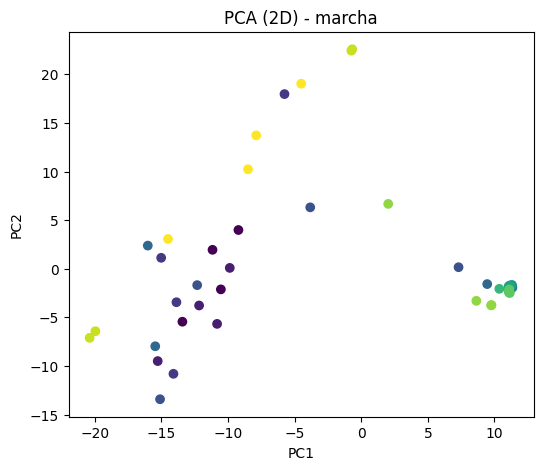

In [8]:
from sklearn.decomposition import PCA

X = data.drop(columns=["person_id","file"])
y = data["person_id"].values

Xn = StandardScaler().fit_transform(X)

Xp = PCA(n_components=2, random_state=0).fit_transform(Xn)

plt.figure(figsize=(6,5))
plt.scatter(Xp[:,0], Xp[:,1], c=y)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA (2D) - marcha")
plt.show()

## Matriz de confusion

Se calculó la matriz de confusión usando validación cruzada estratificada.
Se observa confusión principalmente entre distintas personas, lo cual es consistente con el traslape observado en la proyección PCA.

La matriz de confusión muestra que, aunque varios sujetos son correctamente identificados, existe confusión entre distintas clases, observándose errores repartidos entre diferentes participantes. Esto indica que los descriptores de marcha aún presentan traslape entre clases, lo cual coincide con lo observado en el análisis con PCA.

<Figure size 800x800 with 0 Axes>

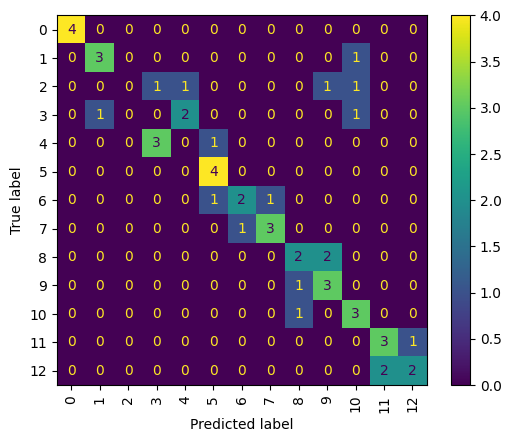

In [9]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

model = LinearSVC(class_weight="balanced", max_iter=20000)

y_pred = cross_val_predict(model, Xn, y, cv=cv)

cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8,8))
disp.plot(xticks_rotation=90)
plt.show()

## Modelos de clasificación

Se evaluaron clasificadores supervisados tradicionales (KNN, Random Forest y SVM lineal). Estos modelos operan sobre vectores de características de dimensión fija, por lo que no modelan explícitamente la dinámica temporal de la secuencia.


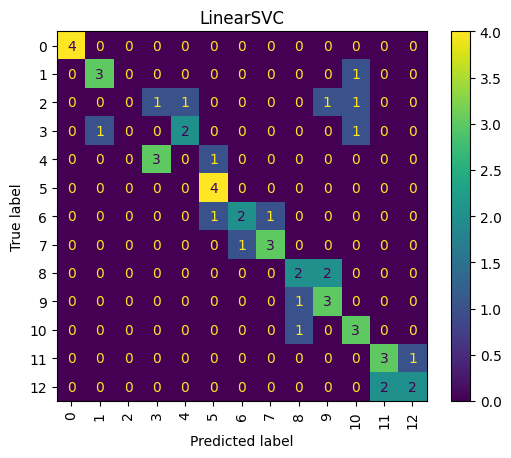

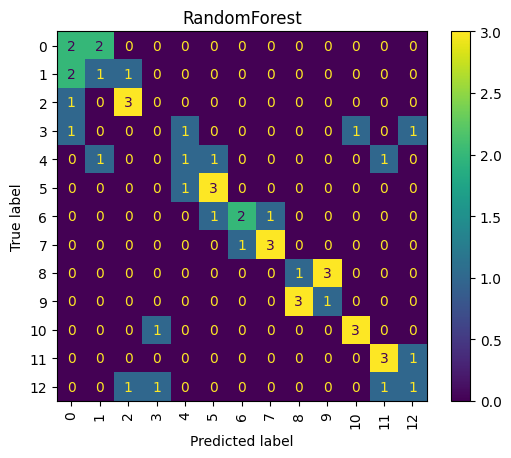

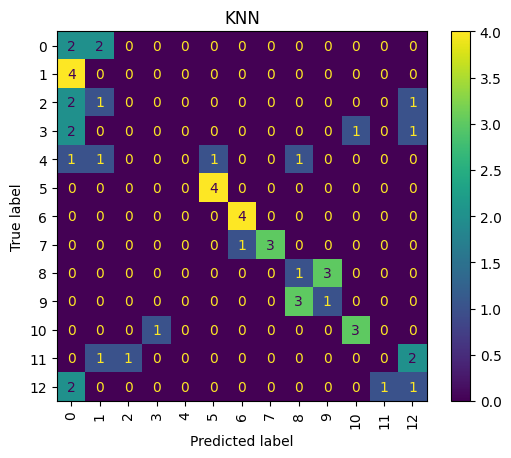

In [10]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

models = {
    "LinearSVC": LinearSVC(class_weight="balanced", max_iter=20000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=0, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=3)
}

for name, model in models.items():

    y_pred = cross_val_predict(model, Xn, y, cv=cv)

    cm = confusion_matrix(y, y_pred)

    disp = ConfusionMatrixDisplay(cm)
    disp.plot(xticks_rotation=90)
    plt.title(name)
    plt.show()

## Validación cruzada

La selección del modelo se realizó mediante validación cruzada estratificada utilizando la métrica F1 macro, con el fin de evaluar el desempeño promedio y su variabilidad entre particiones.


In [11]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

models = {
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "RandomForest (300)": RandomForestClassifier(
        n_estimators=300, random_state=0, class_weight="balanced"
    ),
    "LinearSVC": LinearSVC(
        class_weight="balanced", max_iter=20000
    ),
}


results = []
for name, model in models.items():
    s = cross_val_score(model, Xn, y, cv=cv, scoring="f1_macro")
    results.append({
        "model": name,
        "f1_macro_mean": float(s.mean()),
        "f1_macro_std": float(s.std()),
        "folds": np.round(s, 3)
    })

results_df = pd.DataFrame(results).sort_values(
    "f1_macro_mean", ascending=False
)
results_df = results_df.reset_index(drop=True)

results_df

,model,f1_macro_mean,f1_macro_std,folds
0,LinearSVC,0.477564,0.099875,"[0.513, 0.308, 0.526, 0.564]"
1,RandomForest (300),0.387821,0.121076,"[0.436, 0.269, 0.282, 0.564]"
2,KNN (k=3),0.323718,0.059705,"[0.41, 0.256, 0.282, 0.346]"


## Validación externa

Una vez seleccionado el modelo final, se construyó un conjunto de prueba independiente que no fue utilizado durante el entrenamiento ni la selección del modelo. Este conjunto se emplea exclusivamente para evaluar el desempeño final.

In [12]:
POSE_VAL = "pose_validacion"   # Pose de conjunto de validacion

In [13]:
POSE_VAL = "pose_validacion"

rows_val = []
for f in glob.glob(os.path.join(POSE_VAL, "*_pose.csv")):
    feats = features_from_csv(f)   # la MISMA función que ya usaste
    if not feats:
        continue
    feats["file"] = os.path.basename(f)
    rows_val.append(feats)

val = pd.DataFrame(rows_val).fillna(0)
val.shape

(12, 199)

In [14]:
X_val = val.reindex(columns=X.columns, fill_value=0)

In [15]:
scaler = StandardScaler()
Xn = scaler.fit_transform(X)   # fit con entrenamiento

In [16]:
Xn_val = scaler.transform(X_val)

## Predicción en conjunto de prueba


In [17]:
final_model = LinearSVC(class_weight="balanced", max_iter=20000)
final_model.fit(Xn, y)

pred = final_model.predict(Xn_val)

out = pd.DataFrame({
    "file": val["file"],
    "pred_person_id": pred
}).sort_values("file")

out

,file,pred_person_id
0,grabacion_20260206_163238_pose.csv,2
1,grabacion_20260206_163329_pose.csv,2
2,grabacion_20260206_163516_pose.csv,9
3,grabacion_20260206_163718_pose.csv,11
4,grabacion_20260206_163749_pose.csv,2
5,grabacion_20260206_163827_pose.csv,9
6,grabacion_20260206_163934_pose.csv,2
7,grabacion_20260206_164008_pose.csv,2
8,grabacion_20260206_164123_pose.csv,2
9,grabacion_20260206_164209_pose.csv,2


## Análisis cualitativo de errores

Como el conjunto de prueba es pequeño, se revisaron manualmente todos los videos para entender mejor cuándo el modelo acierta y cuándo se equivoca.

Al ver los videos, se notó que muchos errores aparecen cuando la persona no camina de forma continua y hace otras acciones durante la grabación, por ejemplo: ver la hora, sacar el celular del bolsillo, cargar un termo o una taza de café, o detenerse un momento. En esos casos, los movimientos de brazos, manos y hombros cambian bastante y el patrón ya no corresponde únicamente a una caminata.

También se observó que en varios videos la detección de la pose no es estable, sobre todo en brazos, manos y hombros. Esto pasa principalmente cuando la persona realiza movimientos adicionales con los brazos o cuando la cámara se traba por momentos. En algunos videos incluso aparece otra persona en el fondo, lo que hace que el esqueleto se detecte de forma irregular.

Un comportamiento que se repite es que varias secuencias de personas que no pertenecen a las clases de entrenamiento terminan siendo clasificadas siempre como las mismas identidades. En particular, varias secuencias desconocidas fueron asignadas repetidamente a las mismas dos personas del conjunto de entrenamiento. Esto sugiere que el modelo no está aprendiendo características propias de cada individuo, sino patrones generales de movimiento y también cierto ruido de la detección.

Además, se observó que incluso para una misma persona del conjunto de entrenamiento, diferentes videos pueden ser clasificados en identidades distintas cuando la forma de caminar cambia o cuando durante la grabación la persona realiza algún gesto con los brazos o se detiene brevemente. Esto muestra que existe una variación importante entre videos de un mismo sujeto.

Finalmente, se detectó que los videos donde aparecen muchos landmarks con coordenadas nulas o donde la pose se pierde de manera intermitente son los que presentan más errores. En estos casos, la información disponible para describir el movimiento es limitada y el vector de características deja de representar correctamente la caminata.

En general, a partir de esta revisión visual se puede concluir que el desempeño del modelo depende fuertemente de que la caminata sea continua y de que la estimación de la pose sea estable. Cuando aparecen acciones adicionales con los brazos, interrupciones en la trayectoria o problemas en la detección de landmarks, el modelo tiende a confundirse.


## Conclusión

Se logró construir un pipeline completo para la identificación de personas a partir de secuencias de caminata usando landmarks corporales y modelos de clasificación tradicionales. El enfoque permitió evaluar de forma práctica las limitaciones de representar una secuencia únicamente mediante descriptores estadísticos. En general, los resultados muestran que el método funciona como una aproximación inicial, pero que para un problema de identificación más robusto sería necesario incorporar información temporal y un diseño de características más específico para la marcha.

